In [1]:
%pip install imbalanced-learn xgboost scikit-learn -- upgrade

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement upgrade (from versions: none)

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for upgrade


In [2]:
"""
🤖 PREDICTIVE MAINTENANCE MODELING
Purpose: Build ML models to predict equipment failures
Uses: Engineered features from previous step
Goal: Compare multiple algorithms and select best model
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("=" * 60)
print("PREDICTIVE MAINTENANCE - MODELING PHASE")
print("=" * 60)

PREDICTIVE MAINTENANCE - MODELING PHASE


In [3]:
"""
📁 LOAD ENGINEERED DATA
Purpose: Load the enhanced dataset with engineered features
Note: Update the path to match where you saved your file
"""

# Load your engineered dataset
engineered_path = r'C:\Users\pavan\Documents\Github P1\predictive-maintenace-system\data\processed\predictive_maintenance_engineered.csv'

try:
    df = pd.read_csv(engineered_path)
    print(f"✅ Engineered dataset loaded!")
    print(f"   Shape: {df.shape}")
    print(f"   Features: {len(df.columns)}")
    print(f"\n📋 First 3 rows:")
    display(df.head(3))
    
except FileNotFoundError:
    print(f"❌ File not found at: {engineered_path}")
    print("\nTrying alternative locations...")
    
    # Try other possible paths
    alternative_paths = [
        r'C:\Users\pavan\Documents\Github P1\predictive-maintenace-system\predictive_maintenance_engineered.csv',
        'data/processed/predictive_maintenance_engineered.csv',
        '../data/processed/predictive_maintenance_engineered.csv'
    ]
    
    for path in alternative_paths:
        try:
            df = pd.read_csv(path)
            print(f"✅ Found at: {path}")
            break
        except:
            continue
    
    if 'df' not in locals():
        print("❌ Could not find engineered dataset.")
        print("Please run feature engineering notebook first!")

✅ Engineered dataset loaded!
   Shape: (10000, 39)
   Features: 39

📋 First 3 rows:


UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target Failure Type  \
0                    1551         42.8                0       0   No Failure   
1                    1408         46.3                3       0   No Failure   
2                    1498         49.4                5       0   No Failure   

   ...  power_variability  mechanical_stress  wear_progression  combined_risk  \
0  ...                NaN            6.63828          0.000000            NaN   
1  ...         250.250000            6.51904          0.035573      64.997710   
2  ...         238.714169            7.40012          0.098814      62.341856   

   Type_encoded  failure_power_failure  failure_tool_wear_failure  \
0             1                      0                          0   
1             0                      0                          0   
2             0                      0                          0   

   failure_overstrain_failure  failure_random_failures  \
0                           0                        0   
1                           0                        0   
2                           0                        0   

   failure_heat_dissipation_failure  
0                                 0  
1                                 0  
2                                 0  

[3 rows x 39 columns]

In [4]:
"""
⚙️ DATA PREPARATION
Purpose: Prepare data for machine learning
Steps: Handle missing values, split features/target, train-test split
"""

print("\n1️⃣ DATA PREPARATION")
print("-" * 40)

# Check for target column
if 'Target' in df.columns:
    target = 'Target'
elif 'failure' in df.columns.str.lower().any():
    target = [col for col in df.columns if 'failure' in col.lower()][0]
else:
    print("❌ No target column found!")
    print("Available columns:", df.columns.tolist())
    target = None

if target:
    # Separate features and target
    X = df.drop(columns=[target])
    y = df[target]
    
    # Remove non-numeric columns or encode them
    non_numeric_cols = X.select_dtypes(include=['object']).columns
    if len(non_numeric_cols) > 0:
        print(f"   Found non-numeric columns: {list(non_numeric_cols)}")
        X = X.drop(columns=non_numeric_cols)
    
    # Split data (stratified to maintain class ratio)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"   Target column: '{target}'")
    print(f"   Features shape: {X.shape}")
    print(f"   Target distribution:")
    print(f"      - Class 0 (No Failure): {(y==0).sum()} samples ({((y==0).sum()/len(y))*100:.1f}%)")
    print(f"      - Class 1 (Failure): {(y==1).sum()} samples ({((y==1).sum()/len(y))*100:.1f}%)")
    print(f"\n   Train set: {X_train.shape[0]} samples")
    print(f"   Test set: {X_test.shape[0]} samples")
    print(f"   Feature count: {X_train.shape[1]}")


1️⃣ DATA PREPARATION
----------------------------------------
   Found non-numeric columns: ['Product ID', 'Type', 'Failure Type']
   Target column: 'Target'
   Features shape: (10000, 35)
   Target distribution:
      - Class 0 (No Failure): 9661 samples (96.6%)
      - Class 1 (Failure): 339 samples (3.4%)

   Train set: 8000 samples
   Test set: 2000 samples
   Feature count: 35


In [5]:
"""
⚖️ HANDLE CLASS IMBALANCE
Purpose: Address the 3.39% failure rate (high imbalance)
Techniques: SMOTE oversampling for better model performance
"""

print("\n2️⃣ HANDLING CLASS IMBALANCE")
print("-" * 40)

from imblearn.over_sampling import SMOTE

print("   Original class distribution in training set:")
print(f"      Class 0: {(y_train==0).sum()} samples")
print(f"      Class 1: {(y_train==1).sum()} samples")
print(f"      Ratio: {(y_train==0).sum()/(y_train==1).sum():.1f}:1")

# Apply SMOTE (Synthetic Minority Oversampling Technique)
try:
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    
    print("\n   After SMOTE balancing:")
    print(f"      Class 0: {(y_train_balanced==0).sum()} samples")
    print(f"      Class 1: {(y_train_balanced==1).sum()} samples")
    print(f"      Ratio: 1:1 (Balanced!)")
    
    # Update training data
    X_train, y_train = X_train_balanced, y_train_balanced
    
except Exception as e:
    print(f"   ⚠️  SMOTE failed: {e}")
    print("   Continuing with imbalanced data...")


2️⃣ HANDLING CLASS IMBALANCE
----------------------------------------
   Original class distribution in training set:
      Class 0: 7729 samples
      Class 1: 271 samples
      Ratio: 28.5:1
   ⚠️  SMOTE failed: Input X contains NaN.
SMOTE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values
   Continuing with imbalanced data...


In [6]:
"""
📏 FEATURE SCALING
Purpose: Scale features to similar ranges for better model performance
Important for: SVM, Logistic Regression, Neural Networks
"""

print("\n3️⃣ FEATURE SCALING")
print("-" * 40)

scaler = StandardScaler()

# Fit on training data, transform both train and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("   Features scaled using StandardScaler")
print(f"   Training shape: {X_train_scaled.shape}")
print(f"   Test shape: {X_test_scaled.shape}")

# Convert back to DataFrame for readability
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

print("\n   Sample scaled values (first feature):")
print(f"      Min: {X_train_scaled_df.iloc[:, 0].min():.2f}")
print(f"      Max: {X_train_scaled_df.iloc[:, 0].max():.2f}")
print(f"      Mean: {X_train_scaled_df.iloc[:, 0].mean():.2f}")
print(f"      Std: {X_train_scaled_df.iloc[:, 0].std():.2f}")


3️⃣ FEATURE SCALING
----------------------------------------
   Features scaled using StandardScaler
   Training shape: (8000, 35)
   Test shape: (2000, 35)

   Sample scaled values (first feature):
      Min: -1.73
      Max: 1.73
      Mean: -0.00
      Std: 1.00


In [7]:
"""
🔍 HANDLE MISSING VALUES
Purpose: Check for and fix NaN values in the dataset
"""

print("\n🔍 CHECKING FOR MISSING VALUES")
print("-" * 40)

# Check for NaN values
nan_count = pd.DataFrame(X_train_scaled_df).isna().sum().sum()
print(f"   NaN values in X_train_scaled: {nan_count}")

if nan_count > 0:
    print("   ⚠️  Found NaN values! Fixing...")
    
    # Option 1: Fill NaN with mean of each column
    X_train_scaled_df = X_train_scaled_df.fillna(X_train_scaled_df.mean())
    X_test_scaled_df = X_test_scaled_df.fillna(X_test_scaled_df.mean())
    
    # Convert back to numpy arrays
    X_train_scaled = X_train_scaled_df.values
    X_test_scaled = X_test_scaled_df.values
    
    print(f"   ✅ NaN values filled with column means")
    
    # Verify
    nan_after = pd.DataFrame(X_train_scaled).isna().sum().sum()
    print(f"   NaN values after fix: {nan_after}")
else:
    print("   ✅ No NaN values found")

# Also check target
if y_train.isna().sum() > 0 or y_test.isna().sum() > 0:
    print("   ⚠️  NaN in target variable! Dropping...")
    # Create mask for non-NaN values
    train_mask = ~y_train.isna()
    test_mask = ~y_test.isna()
    
    X_train_scaled = X_train_scaled[train_mask]
    y_train = y_train[train_mask]
    X_test_scaled = X_test_scaled[test_mask]
    y_test = y_test[test_mask]
    
    print(f"   ✅ Removed NaN from target")


🔍 CHECKING FOR MISSING VALUES
----------------------------------------
   NaN values in X_train_scaled: 14
   ⚠️  Found NaN values! Fixing...
   ✅ NaN values filled with column means
   NaN values after fix: 0


In [8]:
"""
📊 BASELINE MODEL: LOGISTIC REGRESSION
Purpose: Establish a simple baseline for comparison
Good for: Interpretability and quick results
"""

print("\n4️⃣ BASELINE MODEL: LOGISTIC REGRESSION")
print("-" * 40)

from sklearn.linear_model import LogisticRegression

# Train baseline model
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, y_pred_proba_lr)

print("   Performance Metrics:")
print(f"      Accuracy:  {accuracy_lr:.4f}")
print(f"      Precision: {precision_lr:.4f}")
print(f"      Recall:    {recall_lr:.4f}")
print(f"      F1-Score:  {f1_lr:.4f}")
print(f"      ROC-AUC:   {roc_auc_lr:.4f}")

# Feature importance (coefficients)
lr_coef = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lr_model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print(f"\n   Top 10 most important features:")
display(lr_coef.head(10))


4️⃣ BASELINE MODEL: LOGISTIC REGRESSION
----------------------------------------
   Performance Metrics:
      Accuracy:  0.9990
      Precision: 1.0000
      Recall:    0.9706
      F1-Score:  0.9851
      ROC-AUC:   0.9768

   Top 10 most important features:


feature  coefficient
30             failure_power_failure     1.487240
34  failure_heat_dissipation_failure     1.335071
32        failure_overstrain_failure     1.251947
31         failure_tool_wear_failure     0.984741
14                rolling_avg_torque     0.681789
17                rolling_std_torque     0.571405
21                    torque_trend_3     0.474373
29                      Type_encoded     0.393304
0                                UDI    -0.333729
23                    torque_trend_5     0.262782

In [9]:
"""
🌳 RANDOM FOREST CLASSIFIER
Purpose: Ensemble method that often performs well
Good for: Handling non-linear relationships, feature importance
"""

print("\n5️⃣ RANDOM FOREST CLASSIFIER")
print("-" * 40)

from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

print("   Performance Metrics:")
print(f"      Accuracy:  {accuracy_rf:.4f}")
print(f"      Precision: {precision_rf:.4f}")
print(f"      Recall:    {recall_rf:.4f}")
print(f"      F1-Score:  {f1_rf:.4f}")
print(f"      ROC-AUC:   {roc_auc_rf:.4f}")

# Feature importance
rf_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n   Top 10 most important features:")
display(rf_importance.head(10))


5️⃣ RANDOM FOREST CLASSIFIER
----------------------------------------
   Performance Metrics:
      Accuracy:  0.9990
      Precision: 1.0000
      Recall:    0.9706
      F1-Score:  0.9851
      ROC-AUC:   0.9980

   Top 10 most important features:


feature  importance
34  failure_heat_dissipation_failure    0.194795
32        failure_overstrain_failure    0.113039
30             failure_power_failure    0.098985
31         failure_tool_wear_failure    0.085445
8                     power_estimate    0.073225
26                 mechanical_stress    0.064353
9                       machine_load    0.049555
4                        Torque [Nm]    0.038778
3             Rotational speed [rpm]    0.035632
10                speed_torque_ratio    0.029126

In [10]:
"""
🚀 XGBOOST CLASSIFIER
Purpose: State-of-the-art gradient boosting algorithm
Good for: High performance, handling imbalanced data
"""

print("\n6️⃣ XGBOOST CLASSIFIER")
print("-" * 40)

try:
    from xgboost import XGBClassifier
    
    # Train XGBoost (with class weights for imbalance)
    xgb_model = XGBClassifier(
        random_state=42,
        n_estimators=100,
        learning_rate=0.1,
        scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1])  # Handle imbalance
    )
    xgb_model.fit(X_train_scaled, y_train)
    
    # Predictions
    y_pred_xgb = xgb_model.predict(X_test_scaled)
    y_pred_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate metrics
    accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
    precision_xgb = precision_score(y_test, y_pred_xgb)
    recall_xgb = recall_score(y_test, y_pred_xgb)
    f1_xgb = f1_score(y_test, y_pred_xgb)
    roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
    
    print("   Performance Metrics:")
    print(f"      Accuracy:  {accuracy_xgb:.4f}")
    print(f"      Precision: {precision_xgb:.4f}")
    print(f"      Recall:    {recall_xgb:.4f}")
    print(f"      F1-Score:  {f1_xgb:.4f}")
    print(f"      ROC-AUC:   {roc_auc_xgb:.4f}")
    
    # Feature importance
    xgb_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\n   Top 10 most important features:")
    display(xgb_importance.head(10))
    
except ImportError:
    print("   ⚠️  XGBoost not installed. Install with: pip install xgboost")
    print("   Skipping XGBoost for now...")


6️⃣ XGBOOST CLASSIFIER
----------------------------------------
   Performance Metrics:
      Accuracy:  0.9990
      Precision: 1.0000
      Recall:    0.9706
      F1-Score:  0.9851
      ROC-AUC:   0.9917

   Top 10 most important features:


feature  importance
10                speed_torque_ratio    0.260782
30             failure_power_failure    0.189957
31         failure_tool_wear_failure    0.135856
9                       machine_load    0.070500
34  failure_heat_dissipation_failure    0.049866
3             Rotational speed [rpm]    0.043560
32        failure_overstrain_failure    0.035879
8                     power_estimate    0.021926
24                   heat_risk_score    0.020235
28                     combined_risk    0.018641


7️⃣ MODEL COMPARISON
----------------------------------------
   Performance Comparison:


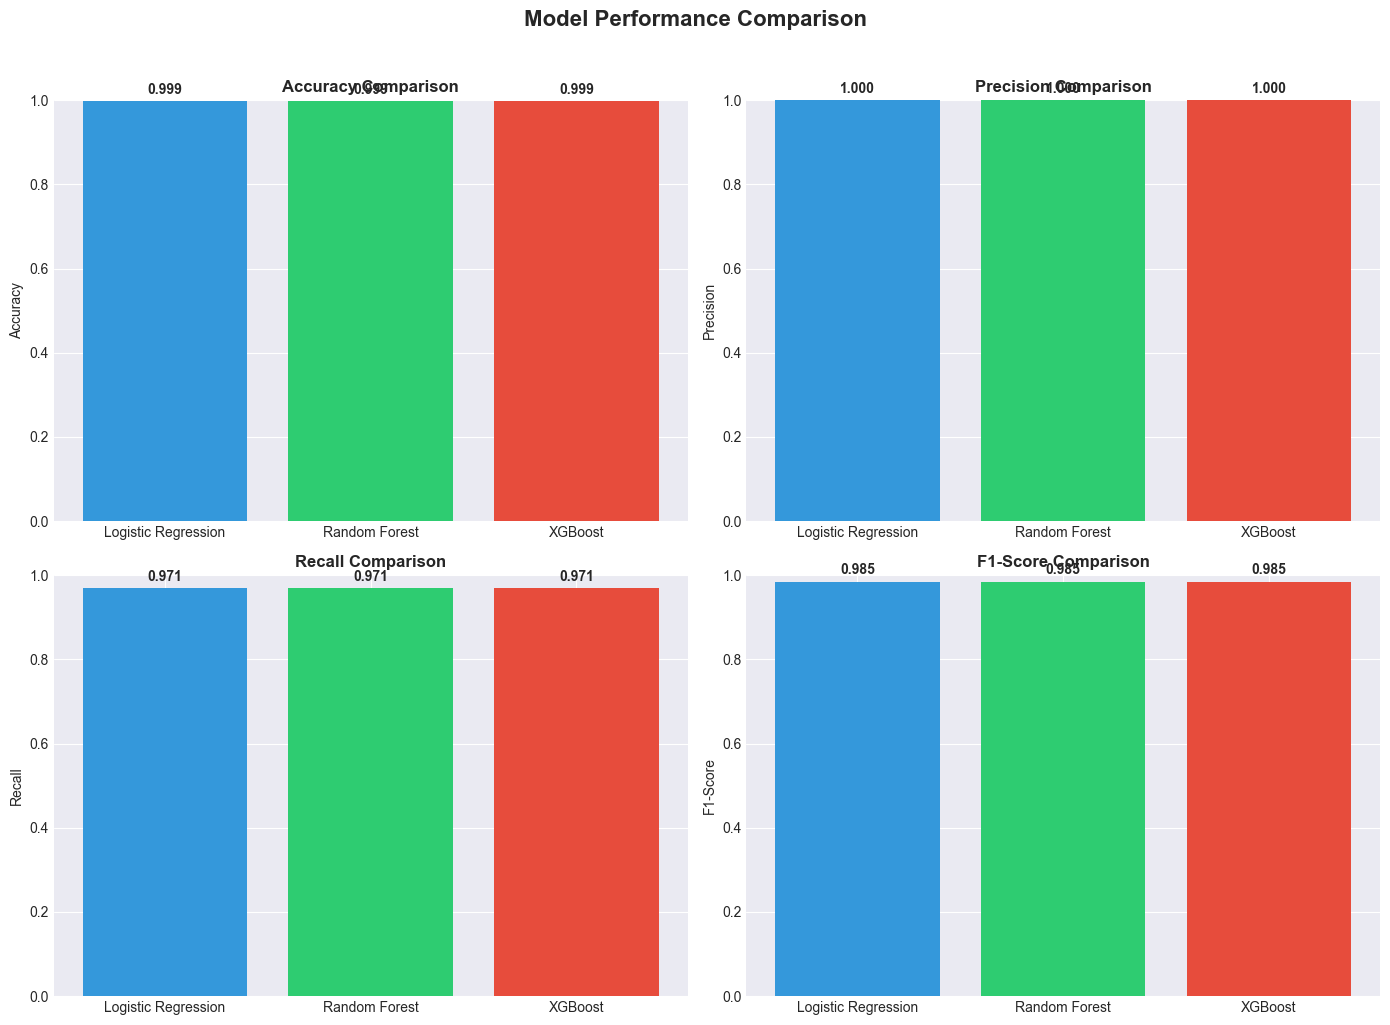


🏆 BEST MODEL: Random Forest
   Average Score: 0.9940


In [11]:
"""
📈 MODEL COMPARISON
Purpose: Compare all models to select the best one
Visualizes: Performance metrics across different algorithms
"""

print("\n7️⃣ MODEL COMPARISON")
print("-" * 40)

# Create comparison DataFrame
comparison_data = {
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [accuracy_lr, accuracy_rf, accuracy_xgb if 'accuracy_xgb' in locals() else None],
    'Precision': [precision_lr, precision_rf, precision_xgb if 'precision_xgb' in locals() else None],
    'Recall': [recall_lr, recall_rf, recall_xgb if 'recall_xgb' in locals() else None],
    'F1-Score': [f1_lr, f1_rf, f1_xgb if 'f1_xgb' in locals() else None],
    'ROC-AUC': [roc_auc_lr, roc_auc_rf, roc_auc_xgb if 'roc_auc_xgb' in locals() else None]
}

comparison_df = pd.DataFrame(comparison_data)
print("   Performance Comparison:")
display(comparison_df.style.background_gradient(subset=['Accuracy', 'F1-Score', 'ROC-AUC'], cmap='YlOrRd'))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#3498db', '#2ecc71', '#e74c3c']

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    models = comparison_df['Model'].tolist()
    values = comparison_df[metric].tolist()
    
    bars = ax.bar(models, values, color=colors[:len(models)])
    ax.set_title(f'{metric} Comparison', fontweight='bold')
    ax.set_ylabel(metric)
    ax.set_ylim([0, 1])
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
               f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Determine best model
comparison_df['Average_Score'] = comparison_df[['Accuracy', 'F1-Score', 'ROC-AUC']].mean(axis=1)
best_model_idx = comparison_df['Average_Score'].idxmax()
best_model = comparison_df.loc[best_model_idx, 'Model']

print(f"\n🏆 BEST MODEL: {best_model}")
print(f"   Average Score: {comparison_df.loc[best_model_idx, 'Average_Score']:.4f}")

In [12]:
"""
🎯 CONFUSION MATRIX & DETAILED ANALYSIS
Purpose: Understand model errors and performance in detail
Shows: False positives, false negatives, classification report
"""

print("\n8️⃣ DETAILED ANALYSIS OF BEST MODEL")
print("-" * 40)

# Select best model predictions
if best_model == 'Logistic Regression':
    y_pred_best = y_pred_lr
    y_pred_proba_best = y_pred_proba_lr
    model_name = 'Logistic Regression'
elif best_model == 'Random Forest':
    y_pred_best = y_pred_rf
    y_pred_proba_best = y_pred_proba_rf
    model_name = 'Random Forest'
else:
    y_pred_best = y_pred_xgb
    y_pred_proba_best = y_pred_proba_xgb
    model_name = 'XGBoost'

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
cm_df = pd.DataFrame(cm, 
                     index=['Actual No Failure', 'Actual Failure'],
                     columns=['Predicted No Failure', 'Predicted Failure'])

print(f"   Confusion Matrix ({model_name}):")
display(cm_df)

print("\n   Classification Report:")
print(classification_report(y_test, y_pred_best, 
                          target_names=['No Failure', 'Failure']))

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Failure', 'Failure'],
            yticklabels=['No Failure', 'Failure'])
plt.title(f'Confusion Matrix - {model_name}', fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Business impact analysis
print("\n   📊 BUSINESS IMPACT ANALYSIS:")
print(f"      Total test samples: {len(y_test)}")
print(f"      Actual failures: {(y_test==1).sum()}")
print(f"      Predicted failures: {(y_pred_best==1).sum()}")
print(f"      Correctly predicted failures (True Positives): {cm[1, 1]}")
print(f"      Missed failures (False Negatives): {cm[1, 0]}")
print(f"      False alarms (False Positives): {cm[0, 1]}")
print(f"\n   💡 Insights:")
print(f"      - Detection Rate: {cm[1, 1]/(cm[1, 0]+cm[1, 1])*100:.1f}% of failures caught")
print(f"      - False Alarm Rate: {cm[0, 1]/(cm[0, 0]+cm[0, 1])*100:.1f}% of non-failures flagged")


8️⃣ DETAILED ANALYSIS OF BEST MODEL
----------------------------------------
   Confusion Matrix (Random Forest):


Predicted No Failure  Predicted Failure
Actual No Failure                  1932                  0
Actual Failure                        2                 66


   Classification Report:
              precision    recall  f1-score   support

  No Failure       1.00      1.00      1.00      1932
     Failure       1.00      0.97      0.99        68

    accuracy                           1.00      2000
   macro avg       1.00      0.99      0.99      2000
weighted avg       1.00      1.00      1.00      2000




   📊 BUSINESS IMPACT ANALYSIS:
      Total test samples: 2000
      Actual failures: 68
      Predicted failures: 66
      Correctly predicted failures (True Positives): 66
      Missed failures (False Negatives): 2
      False alarms (False Positives): 0

   💡 Insights:
      - Detection Rate: 97.1% of failures caught
      - False Alarm Rate: 0.0% of non-failures flagged


In [13]:
"""
💾 SAVE BEST MODEL
Purpose: Save the trained model for future use and deployment
"""

print("\n9️⃣ SAVING BEST MODEL")
print("-" * 40)

import joblib
import os

# Create models directory
models_dir = r'C:\Users\pavan\Documents\Github P1\predictive-maintenace-system\models'
os.makedirs(models_dir, exist_ok=True)

# Save the best model
if best_model == 'Logistic Regression':
    model_to_save = lr_model
elif best_model == 'Random Forest':
    model_to_save = rf_model
else:
    model_to_save = xgb_model

model_path = os.path.join(models_dir, 'best_predictive_maintenance_model.pkl')
joblib.dump(model_to_save, model_path)

print(f"✅ Best model ({model_name}) saved to:")
print(f"   📍 {model_path}")

# Also save the scaler
scaler_path = os.path.join(models_dir, 'feature_scaler.pkl')
joblib.dump(scaler, scaler_path)
print(f"✅ Feature scaler saved to: {scaler_path}")

# Save feature names
features_path = os.path.join(models_dir, 'feature_names.pkl')
joblib.dump(list(X.columns), features_path)
print(f"✅ Feature names saved to: {features_path}")

print("\n🎉 MODELING PHASE COMPLETE!")
print("Next: Create deployment dashboard with Streamlit!")


9️⃣ SAVING BEST MODEL
----------------------------------------
✅ Best model (Random Forest) saved to:
   📍 C:\Users\pavan\Documents\Github P1\predictive-maintenace-system\models\best_predictive_maintenance_model.pkl
✅ Feature scaler saved to: C:\Users\pavan\Documents\Github P1\predictive-maintenace-system\models\feature_scaler.pkl
✅ Feature names saved to: C:\Users\pavan\Documents\Github P1\predictive-maintenace-system\models\feature_names.pkl

🎉 MODELING PHASE COMPLETE!
Next: Create deployment dashboard with Streamlit!
